# **Cp time series forecasting: RNN family**

TO DO: Description here

# Setup environment

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

In [2]:
workDir = os.getcwd()
print(workDir)
figDir = (r"c:\Users\Tsinu\OneDrive - The University of Western Ontario\Documents"
    r"\Courses\ECE_9603A_DataAnalytics\Assignments\Assignment_1\documents\figures" )
cpFile = 'data/velAndCp_ttuMSop0900.4.csv'

print(figDir)

# device = torch.device("cuda:0") 

c:\Users\Tsinu\OneDrive - The University of Western Ontario\Documents\Courses\ECE_9603A_DataAnalytics\Assignments\Assignment_1\workshop
c:\Users\Tsinu\OneDrive - The University of Western Ontario\Documents\Courses\ECE_9603A_DataAnalytics\Assignments\Assignment_1\documents\figures


# Data preparation

## Read data from file and inspect

         time        U         V         W    ABCD_7   ABCD_12   ABCD_43
0       0.002  6.49800  0.134393 -0.438469  0.813612 -1.022267 -0.219312
1       0.004  6.37181  0.184916 -0.253927  0.762472 -0.927593 -0.209720
2       0.006  6.28931  0.130323  0.291360  0.722682 -0.915229 -0.220613
3       0.008  6.09528  0.517966  0.190536  0.723964 -0.712760 -0.268550
4       0.010  5.85722  0.788368 -0.060864  0.715083 -0.863715 -0.242386
...       ...      ...       ...       ...       ...       ...       ...
34995  69.992  5.27989 -0.451910  0.636471  0.465865 -0.832728 -0.106069
34996  69.994  5.52606 -0.025726  0.123668  0.454852 -0.831146 -0.111166
34997  69.996  5.54582 -0.007649  0.017991  0.441649 -0.796670 -0.128197
34998  69.998  5.51319 -0.070082  0.100660  0.435023 -0.811094 -0.136843
34999  70.000  5.62022 -0.050636  0.213426  0.426556 -0.763971 -0.143850

[35000 rows x 7 columns]


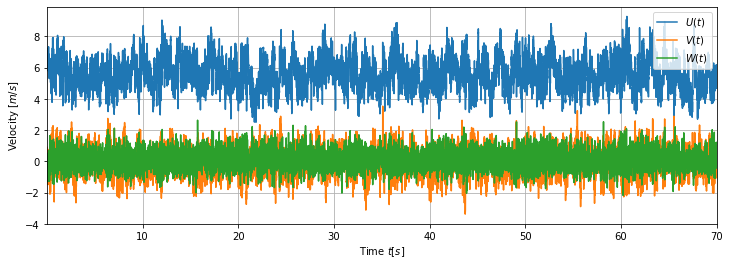

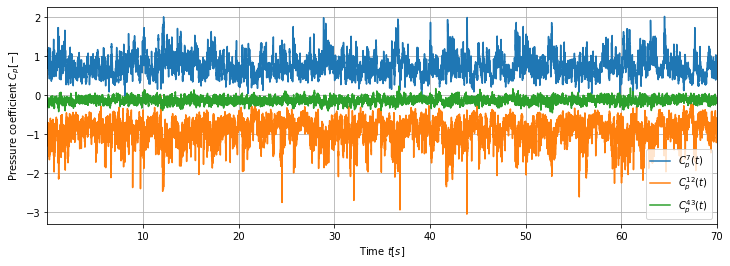

In [3]:
# Load all data for description purpose (velocity and Cp)
origData = pd.read_csv(cpFile,delimiter=',',usecols=[0,1,2,3,4,5,6])
_time = origData.time
print(origData)

# Velocity data
plt.figure(figsize = (12,4))
plt.xlim(origData.time.values[0], origData.time.values[-1])
plt.grid(True)
plt.plot(origData.time,origData.U,label='$U(t)$')
plt.plot(origData.time,origData.V,label='$V(t)$')
plt.plot(origData.time,origData.W,label='$W(t)$')
plt.xlabel('Time $t[s]$')
plt.ylabel('Velocity $[m/s]$')
plt.legend()
# plt.savefig(figDir+r'\plot_rawVelData.svg',format='svg')

# Cp data
plt.figure(figsize = (12,4))
plt.xlim(origData.time.values[0], origData.time.values[-1])
plt.grid(True)
plt.plot(origData.time,origData.ABCD_7,label='$C_p^{7}(t)$')
plt.plot(origData.time,origData.ABCD_12,label='$C_p^{12}(t)$')
plt.plot(origData.time,origData.ABCD_43,label='$C_p^{43}(t)$')
plt.xlabel('Time $t[s]$')
plt.ylabel('Pressure coefficient $C_p[-]$')
plt.legend()
# plt.savefig(figDir+r'\plot_rawCpData.svg',format='svg')

del origData # clear the complete dataset

### Select data for scope of assignment 1

In [4]:
# Read selected columns (Cp for P7, P12, and P43)
data = pd.read_csv(cpFile,delimiter=',',usecols=[4,5,6]) 

# Number of time steps to take
N = 5000
data = data.truncate(0,N-1)
_time = _time[:N-1]
data = data.values
N_total = len(data)

print(data)
print(N_total)

[[ 0.81361177 -1.02226712 -0.21931246]
 [ 0.76247185 -0.92759344 -0.20971965]
 [ 0.72268155 -0.91522857 -0.22061262]
 ...
 [ 0.99780794 -1.25253813 -0.12101058]
 [ 1.00736693 -1.44954116 -0.08359275]
 [ 1.01726066 -1.38910078 -0.08304811]]
5000


## Prepare data

In [5]:
# divide the data into number of steps 
# Inputs: data, input window size, lag size, output label size
def reshapeData(data, N_w, N_l, N_o):
    N = len(data)
    N_b = int(np.floor((N - (N_w + N_o)) / N_l))
    X = []
    Y = []
    for i in range(N_b):
        iStart, iEnd = i*N_l, i*N_l + N_w
        X.append(data[iStart:iEnd])
        iStart, iEnd = i*N_l + N_w, i*N_l + N_w + N_o
        Y.append(data[iStart:iEnd])
    return X, Y

In [6]:
windowSize = 70
lagSize = 1 
outputSize = 1
# Note: current implementation works with lag and output sizes of 1

# breakdown the input ensemble of time series into batch of examples
x, y = reshapeData(data,windowSize, lagSize, outputSize)

# convert the x and y values into arrays
x, y = np.asarray(x), np.asarray(y)

# **Temporary** Squeeze the output to eliminate the extra dimension
y = y.squeeze()

# make sure the shape of x contains the window size
x.reshape(-1,windowSize).shape

print("Shape of batched data x: {}".format(np.shape(x)))
print("Shape of corresponding labels y: {}".format(np.shape(y)))

Shape of batched data x: (4929, 70, 3)
Shape of corresponding labels y: (4929, 3)


In [7]:
# divide the data into train and test
def split_data(x, y, rTrain, rValid):
    assert len(x)==len(y)
    N = len(x)
    a, b = int(N*rTrain), int(N*rTrain)+int(N*rValid)
    train_x, valid_x, test_x  = x[:a], x[a:b], x[b:]
    train_y, valid_y, test_y  = y[:a], y[a:b], y[b:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

In [8]:
# Training, validation, and test set fractions
rTrain = 0.6
rValid = 0.2
# rTest = 0.2 # deduced from the other two

# Split data into training, validation, and test sets
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(
    x, y, rTrain, rValid
)
print("Shape of \t Training \t x: {} \t y: {}".format(
    x_train.shape, y_train.shape))
print("\t\t Validation \t x: {} \t y: {}".format(
    x_valid.shape, y_valid.shape))
print("\t \t Test \t \t x: {} \t y: {}".format(
    x_test.shape, y_test.shape))
# del x, y  # remove these large arrays to save memory

Shape of 	 Training 	 x: (2957, 70, 3) 	 y: (2957, 3)
		 Validation 	 x: (985, 70, 3) 	 y: (985, 3)
	 	 Test 	 	 x: (987, 70, 3) 	 y: (987, 3)


(0.0, 4929.0)

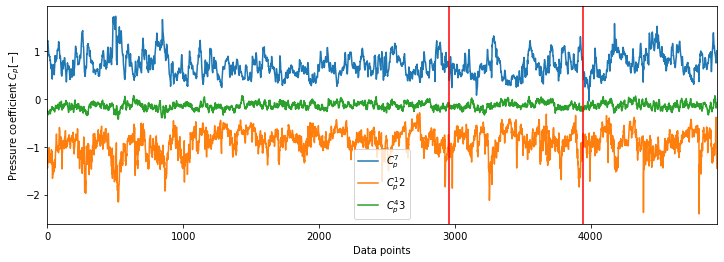

In [9]:
# Plot to show the divided data: outputs from all examples of the batch are stacked, 
# therefore, the length is not N but N_b*N_o
plt.figure(figsize = (12,4))
plt.plot(np.vstack((y_train,y_valid,y_test))[:,0],label=('$C_p^7$'))
plt.plot(np.vstack((y_train,y_valid,y_test))[:,1],label=('$C_p^12$'))
plt.plot(np.vstack((y_train,y_valid,y_test))[:,2],label=('$C_p^43$'))
plt.axvline(int(len(x)*rTrain),color='r')
plt.axvline(int(len(x)*(rTrain+rValid)),color='r')
plt.xlabel('Data points')
plt.ylabel('Pressure coefficient $C_p[-]$')
plt.legend()
plt.xlim(0,len(y))
# plt.savefig(figDir+r'\plot_trainValidTest.svg',format='svg')


In [10]:
# Convert all data to torch tensors
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
x_valid = torch.from_numpy(x_valid.astype(np.float32))
y_valid = torch.from_numpy(y_valid.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Model definition
Four models have been implemented.
* Multilayer perceptron (MLP)
* Vanila recurrent neural network (RNN)
* Long-short-term memory (LSTM)
* Gated recurrent unit (GRU)

## MLP Model

In [11]:
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(MLP,self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim,hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim,hid_dim),
            nn.Linear(in_dim,hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim,out_dim)
        )
    
    def forward(self,x):
        return self.layers(x)

## RNN Model

In [12]:
# Implement the RNN 
class RNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super(RNN, self).__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='tanh', 
                        batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden layer
        h0 = torch.zeros(self.layer, x.size(0),self.hid_dim)
        
        # call the rnn
        out, _ = self.rnn(x,h0)
        
        out = self.fc(out[:,-1,:])
        return out

## LSTM Model

In [13]:
# implement LSTM here
class LSTM(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out

## GRU Model

In [14]:
# implement GRU
class GRU(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, num_layer):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.gru = nn.GRU(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initalize the hidden layers
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        out, _ = self.gru(x,h0)
        out = self.fc(out[:,-1,:])
        return out

## Model instantiation

In [15]:
# Instantiate MLP
in_size = windowSize 
out_size = outputSize
hid_size = 5

modelMLP = MLP(in_size,hid_size,out_size)
optimizerMLP = torch.optim.Adam(modelMLP.parameters(), lr=0.01)

# Instantiate RNN, LSTM, & GRU
in_size = x.shape[-1]
out_size = in_size
hid_size = 5
num_layers = 2

modelRNN = RNN(in_size,hid_size,out_size, num_layers)
modelLSTM = RNN(in_size,hid_size,out_size, num_layers)
modelGRU = GRU(in_size,hid_size,out_size, num_layers)

optimizerRNN = torch.optim.Adam(modelRNN.parameters(), lr=0.01)
optimizerLSTM = torch.optim.Adam(modelLSTM.parameters(), lr=0.01)
optimizerGRU = torch.optim.Adam(modelGRU.parameters(), lr=0.01)

# Common parameters
trainLossFun = nn.MSELoss() # Mean square error for training/validation
evalLossFun = nn.L1Loss() # Mean absolute error for testing

# Training and validation

## Trainer function

In [16]:
def train_model(model,
               loss_fun,
               optimizer,
               train_x,
               valid_x,
               train_y,
               valid_y,
               epochs=500):
    
    trainLoss = np.zeros(epochs)
    validLoss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(train_x)
        
        # calculate the loss 
        error = loss_fun(pred,train_y)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        trainLoss[epoch] = error.item()
        
        # validation loss 
        validPred = model(valid_x)
        validError = loss_fun(valid_y,validPred)
        validLoss[epoch] = validError.item()
        
        if (epoch+1) % 50 ==0:
            print('\tEpoch :{:.1f} %\tTrain Loss :{:.5f}\tValidation Loss :{:.5f}'.format(100*(epoch+1)/epochs, 
                    error.item(), validError.item()))
            
    return trainLoss, validLoss

## Training and validation

In [17]:
# Declare common training parameters
epochs = 500

### Training with MLP

In [18]:
# # Rearrange input to fit input of nn.Linear()
# x_trainMLP, y_trainMLP = rearrangeInputForMLP(x_train, y_train)
# x_validMLP, y_validMLP = rearrangeInputForMLP(x_valid, y_valid)
# x_testMLP, y_testMLP = rearrangeInputForMLP(x_test, y_test)
# # y_trainMLP = y_train[:,:,0]
# # y_validMLP = y_valid[:,:,1]
# # y_testMLP = y_train[:,:,2]

# # torch.reshape(x_trainMLP, (-1, windowSize, 1))
# print(x_valid.shape)
# print(x_validMLP[0].shape)

# print('\nTraining with MLP')
# # trainLossMLP, validLossMLP = train_model(modelMLP, trainLossFun, optimizerMLP,
# #                x_trainMLP[0], x_validMLP[0], y_trainMLP[0], y_validMLP[0], epochs)
# trainLossMLP, validLossMLP = train_model(modelMLP, trainLossFun, optimizerMLP,
#                x_train, x_valid, y_train, y_valid, epochs)

In [19]:
# # Plot loss for MLP
# plt.figure(figsize = (6,4))
# plt.plot(trainLossMLP,label='Training Loss')
# plt.plot(validLossMLP,label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Mean square error')
# plt.xlim(0,epochs)
# # plt.ylim(0, 0.2)
# plt.grid(True)
# plt.legend()
# plt.title('Loss for MLP')
# # plt.savefig(figDir+r'\plot_trainingMLP.svg',format='svg')

In [20]:
print('\nTraining with RNN')
trainLossRNN, validLossRNN = train_model(modelRNN, trainLossFun, optimizerRNN,
               x_train, x_valid, y_train, y_valid, epochs)


Training with RNN
	Epoch :10.0 %	Train Loss :0.03935	Validation Loss :0.04193
	Epoch :20.0 %	Train Loss :0.02243	Validation Loss :0.02197
	Epoch :30.0 %	Train Loss :0.01129	Validation Loss :0.01173
	Epoch :40.0 %	Train Loss :0.00669	Validation Loss :0.00753
	Epoch :50.0 %	Train Loss :0.00580	Validation Loss :0.00684
	Epoch :60.0 %	Train Loss :0.00538	Validation Loss :0.00649
	Epoch :70.0 %	Train Loss :0.00511	Validation Loss :0.00627
	Epoch :80.0 %	Train Loss :0.00493	Validation Loss :0.00611
	Epoch :90.0 %	Train Loss :0.00479	Validation Loss :0.00599
	Epoch :100.0 %	Train Loss :0.00468	Validation Loss :0.00590


Text(0.5, 1.0, 'Loss for RNN')

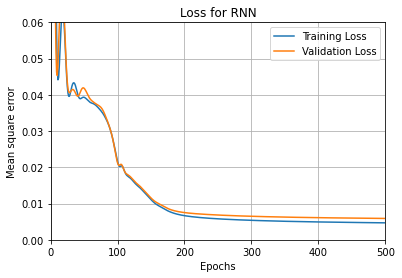

In [21]:
# Plot loss for RNN
plt.figure(figsize = (6,4))
plt.plot(trainLossRNN,label='Training Loss')
plt.plot(validLossRNN,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean square error')
plt.xlim(0,epochs)
plt.ylim(0, 0.06)
plt.grid(True)
plt.legend()
plt.title('Loss for RNN')
# plt.savefig(figDir+r'\plot_trainingRNN.svg',format='svg')

In [22]:
print('\nTraining with LSTM')
trainLossLSTM, validLossLSTM = train_model(modelLSTM, trainLossFun, optimizerLSTM,
               x_train, x_valid, y_train, y_valid, epochs)


Training with LSTM
	Epoch :10.0 %	Train Loss :0.03222	Validation Loss :0.03141
	Epoch :20.0 %	Train Loss :0.01917	Validation Loss :0.01981
	Epoch :30.0 %	Train Loss :0.01542	Validation Loss :0.01631
	Epoch :40.0 %	Train Loss :0.00796	Validation Loss :0.00875
	Epoch :50.0 %	Train Loss :0.00604	Validation Loss :0.00720
	Epoch :60.0 %	Train Loss :0.00536	Validation Loss :0.00655
	Epoch :70.0 %	Train Loss :0.00498	Validation Loss :0.00618
	Epoch :80.0 %	Train Loss :0.00473	Validation Loss :0.00596
	Epoch :90.0 %	Train Loss :0.00455	Validation Loss :0.00580
	Epoch :100.0 %	Train Loss :0.00438	Validation Loss :0.00565


Text(0.5, 1.0, 'Loss for LSTM')

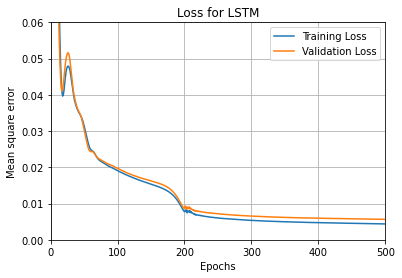

In [23]:
# Plot loss for LSTM
plt.figure(figsize = (6,4))
plt.plot(trainLossLSTM,label='Training Loss')
plt.plot(validLossLSTM,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean square error')
plt.xlim(0,epochs)
plt.ylim(0, 0.06)
plt.grid(True)
plt.legend()
plt.title('Loss for LSTM')
# plt.savefig(figDir+r'\plot_trainingLSTM.svg',format='svg')

In [24]:
print('\nTraining with GRU')
trainLossGRU, validLossGRU = train_model(modelGRU, trainLossFun, optimizerGRU,
               x_train, x_valid, y_train, y_valid, epochs)


Training with GRU
	Epoch :10.0 %	Train Loss :0.03519	Validation Loss :0.03643
	Epoch :20.0 %	Train Loss :0.02469	Validation Loss :0.02428
	Epoch :30.0 %	Train Loss :0.01546	Validation Loss :0.01590
	Epoch :40.0 %	Train Loss :0.01377	Validation Loss :0.01428
	Epoch :50.0 %	Train Loss :0.01048	Validation Loss :0.01087
	Epoch :60.0 %	Train Loss :0.00552	Validation Loss :0.00619
	Epoch :70.0 %	Train Loss :0.00455	Validation Loss :0.00532
	Epoch :80.0 %	Train Loss :0.00415	Validation Loss :0.00499
	Epoch :90.0 %	Train Loss :0.00394	Validation Loss :0.00484
	Epoch :100.0 %	Train Loss :0.00381	Validation Loss :0.00474


Text(0.5, 1.0, 'Loss for GRU')

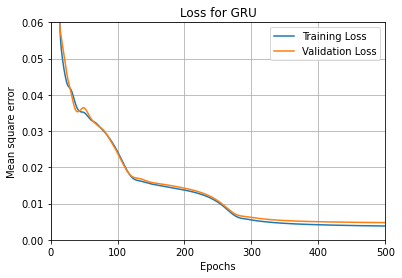

In [25]:
# Plot loss for GRU
plt.figure(figsize = (6,4))
plt.plot(trainLossGRU,label='Training Loss')
plt.plot(validLossGRU,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean square error')
plt.xlim(0,epochs)
plt.ylim(0, 0.06)
plt.grid(True)
plt.legend()
plt.title('Loss for GRU')
# plt.savefig(figDir+r'\plot_trainingGRU.svg',format='svg')

# Evaluation

In [26]:
# Testing
# y_predTestMLP = modelMLP(x_test)
# testLossMLP = evalLossFun(y_test,y_predTestMLP)

y_predTestRNN = modelRNN(x_test)
testLossRNN = evalLossFun(y_test,y_predTestRNN)

y_predTestLSTM = modelLSTM(x_test)
testLossLSTM = evalLossFun(y_test,y_predTestLSTM)

y_predTestGRU = modelGRU(x_test)
testLossGRU = evalLossFun(y_test,y_predTestGRU)

print('Mean absolute error of testing set:')
# print('\t With MLP:\t{:.4f}'.format(testLossMLP))
print('\t With RNN:\t{:.4f}'.format(testLossRNN))
print('\t With LSTM:\t{:.4f}'.format(testLossLSTM))
print('\t With GRU:\t{:.4f}'.format(testLossGRU))

Mean absolute error of testing set:
	 With RNN:	0.0529
	 With LSTM:	0.0507
	 With GRU:	0.0428


(0.0, 4929.0)

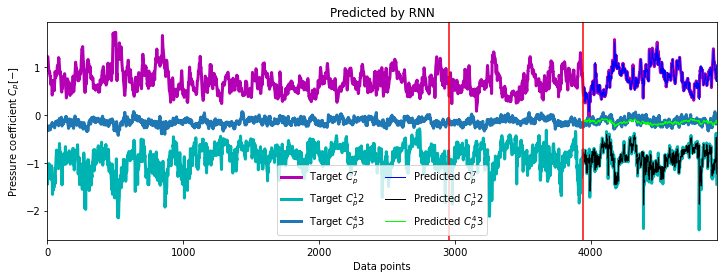

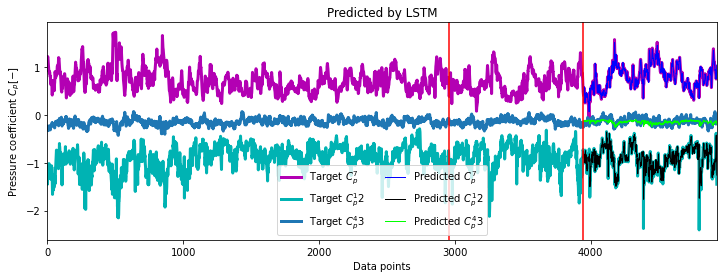

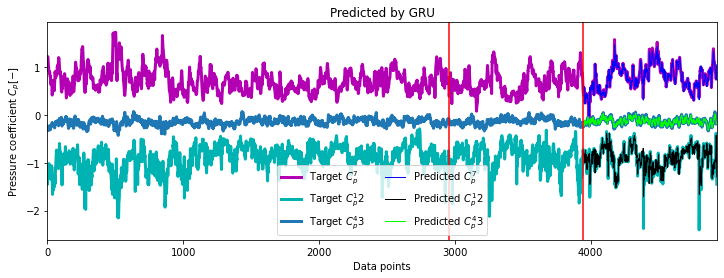

In [27]:
#  Plot of predicted data
t_test = range(len(y_train)+len(y_valid), len(x))

# plt.figure(figsize = (12,4))
# plt.plot(y,label='Target $C_p^7$',linewidth=3,color=(0.7, 0, 0.7, 1))
# # plt.plot(y[:,1],label='Target $C_p^12$',linewidth=3,color=(0, 0.7, 0.7, 1))
# # plt.plot(y[:,2],label='Target $C_p^43$',linewidth=3)
# plt.plot(t_test,y_predTestMLP.detach().numpy().squeeze(),
#     label='Predicted $C_p^7$',linewidth=1,color=(0, 0, 1, 1))
# # plt.plot(t_test,y_predTestMLP.detach().numpy()[:,1],
# #     label='Predicted $C_p^12$',linewidth=1,color=(0, 0, 0, 1))
# # plt.plot(t_test,y_predTestMLP.detach().numpy()[:,2],
# #     label='Predicted $C_p^43$',linewidth=1,color=(0, 1, 0, 1))
# plt.axvline(int(len(x)*rTrain),color='r')
# plt.axvline(int(len(x)*(rTrain+rValid)),color='r')
# plt.xlabel('Data points')
# plt.ylabel('Pressure coefficient $C_p[-]$')
# plt.legend(ncol=2)
# plt.title('Predicted by MLP')
# plt.xlim(0,len(y))
# # plt.savefig(figDir+r'\plot_testingRNN.svg',format='svg')

plt.figure(figsize = (12,4))
plt.plot(y[:,0],label='Target $C_p^7$',linewidth=3,color=(0.7, 0, 0.7, 1))
plt.plot(y[:,1],label='Target $C_p^12$',linewidth=3,color=(0, 0.7, 0.7, 1))
plt.plot(y[:,2],label='Target $C_p^43$',linewidth=3)
plt.plot(t_test,y_predTestRNN.detach().numpy()[:,0],
    label='Predicted $C_p^7$',linewidth=1,color=(0, 0, 1, 1))
plt.plot(t_test,y_predTestRNN.detach().numpy()[:,1],
    label='Predicted $C_p^12$',linewidth=1,color=(0, 0, 0, 1))
plt.plot(t_test,y_predTestRNN.detach().numpy()[:,2],
    label='Predicted $C_p^43$',linewidth=1,color=(0, 1, 0, 1))
plt.axvline(int(len(x)*rTrain),color='r')
plt.axvline(int(len(x)*(rTrain+rValid)),color='r')
plt.xlabel('Data points')
plt.ylabel('Pressure coefficient $C_p[-]$')
plt.legend(ncol=2)
plt.title('Predicted by RNN')
plt.xlim(0,len(y))
# plt.savefig(figDir+r'\plot_testingRNN.svg',format='svg')

plt.figure(figsize = (12,4))
plt.plot(y[:,0],label='Target $C_p^7$',linewidth=3,color=(0.7, 0, 0.7, 1))
plt.plot(y[:,1],label='Target $C_p^12$',linewidth=3,color=(0, 0.7, 0.7, 1))
plt.plot(y[:,2],label='Target $C_p^43$',linewidth=3)
plt.plot(t_test,y_predTestLSTM.detach().numpy()[:,0],
    label='Predicted $C_p^7$',linewidth=1,color=(0, 0, 1, 1))
plt.plot(t_test,y_predTestLSTM.detach().numpy()[:,1],
    label='Predicted $C_p^12$',linewidth=1,color=(0, 0, 0, 1))
plt.plot(t_test,y_predTestLSTM.detach().numpy()[:,2],
    label='Predicted $C_p^43$',linewidth=1,color=(0, 1, 0, 1))
plt.axvline(int(len(x)*rTrain),color='r')
plt.axvline(int(len(x)*(rTrain+rValid)),color='r')
plt.xlabel('Data points')
plt.ylabel('Pressure coefficient $C_p[-]$')
plt.title('Predicted by LSTM')
plt.legend(ncol=2)
plt.xlim(0,len(y))
# plt.savefig(figDir+r'\plot_testingLSTM.svg',format='svg')

plt.figure(figsize = (12,4))
plt.plot(y[:,0],label='Target $C_p^7$',linewidth=3,color=(0.7, 0, 0.7, 1))
plt.plot(y[:,1],label='Target $C_p^12$',linewidth=3,color=(0, 0.7, 0.7, 1))
plt.plot(y[:,2],label='Target $C_p^43$',linewidth=3)
plt.plot(t_test,y_predTestGRU.detach().numpy()[:,0],
    label='Predicted $C_p^7$',linewidth=1,color=(0, 0, 1, 1))
plt.plot(t_test,y_predTestGRU.detach().numpy()[:,1],
    label='Predicted $C_p^12$',linewidth=1,color=(0, 0, 0, 1))
plt.plot(t_test,y_predTestGRU.detach().numpy()[:,2],
    label='Predicted $C_p^43$',linewidth=1,color=(0, 1, 0, 1))
plt.axvline(int(len(x)*rTrain),color='r')
plt.axvline(int(len(x)*(rTrain+rValid)),color='r')
plt.xlabel('Data points')
plt.ylabel('Pressure coefficient $C_p[-]$')
plt.title('Predicted by GRU')
plt.legend(ncol=2)
plt.xlim(0,len(y))
# plt.savefig(figDir+r'\plot_testingGRU.svg',format='svg')